## Quantum Pokemon Classifier

![](img/PokemonWorld.png)

O mundo pokemon é um local vasto, bonito e repleto de regiões, que possibilitam aventuras incriveis para os novos treinadores pokemon a cada geração. Mas além disso, é um mundo formidavel para os pesquisadores, que encaram um novo desafio: Uma região ainda não catalogada e repleta de mistérios e criaturas esperando para serem descobertas.

Nesse contexto, o Professor Carvalho, um pesquisador renomado cujo nome ecoa pelos corredores das mais prestigiadas instituições Pokémon, fica ansioso para começar a explorar e catalogar os Pokémon dessa nova região. No entanto, esse desafio é enorme e ele sabe que não poderia trabalhar nisso sozinho. Assim, ele toma uma decisão crucial: abrir vagas para novos pesquisadores em sua equipe, buscando mentes brilhantes e dispostas a enfrentar os desafios que essa jornada implica.

<!-- <p align="center">
  <img src="image/Professor_Oak_JN_anime.webp" alt="Mundo Pokemon">
</p> -->
![Professor Carvalho](img/Professor_Oak_JN_anime.webp)

A noticia que o professor Carvalho abriu vagas para pesquisadores correm por toda cidade e em questão de horas, centenas de curriculos inundam sua mesa. Assim, o professor começa avaliar um por um dos curriculos dos ansiosos treinadores e pesquisadores Pokémon. Entre eles, um em especial chama a atenção, o seu curriculo!

 Lá estava você, uma pessoa apaixonada pelo o que fazia, destemido e bla bla bla, igual a todas os outros candidatos, mas foi um detalhe em particular que despertou a curiosidade do Professor Carvalho: seu recente interesse e estudo em computação quântica utilizando [Qiskit](https://www.ibm.com/quantum/qiskit).

No entanto, diante da perspetiva de explorar novas fronteiras e desvendar os mistérios do universo Pokémon de maneiras jamais imaginadas, ele decide abrir as portas para essa possibilidade intrigante e te informar para aparecer lá no outro dia de manhã.

No dia seguinte, logo pela manha, você está lá, parado diante da imponente porta do laboratório do Professor Carvalho, acompanhado de seu leal companheiro Pikachu. Em poucos minutos, a imagem do professor vai se construindo no fundo do escuro laboratorio dele e te recebe com um sorriso amigavel.


Ele se apresenta com pressa, mas não perde tempo, e logo te apresenta o seu desafio: ele deseja que você desenvolva um classificador para determinar se o primeiro tipo do Pokémon é normal ou aquático, e propõe a você utilizar computação quântica nessa tarefa. 

OK, agora é com você!

### Exploratory Data Analysis

Sua tarefa agora é criar um classificador que te ajudará na sua jornada em catalogar especies. Para isso, o professor Carvalho te entrega um dataset chamado `pokemon.csv` que ele construiu com anos de pesquisa, contendo dados importantes de Pokémon já catalogados, como nome, tipo, peso, tamanho, fraquezas.

In [26]:
import pandas as pd
data = pd.read_csv('pokemon.csv') # Importando dataset

### Data pre-processing

Agora, você precisa filtrar o dataset, selecionando apenas os Pokémon que correspondem aos tipos água e normal, os focos de sua pesquisa. Essa seleção permitirá que você se concentre nos padrões e características distintivas desses tipos específicos.

Além disso, a escolha das features é um passo importante que devemos dar atenção ao nosso objetivo. Considerando que você não vai deixar o seu leal Pikachu para trás, vamos considerar que ele sabe diversos ataques eletricos, além de recentemente, de maneira estranha, ele aprendeu um ataque do tipo pedra, como o `rock throw` e é essencial incluir informações sobre fraquezas e resistências a ataques elétricos e de pedra.

In [27]:
from sklearn.preprocessing import LabelEncoder
df = data.copy()
df.isnull().sum()
df.columns = df.columns.str.strip()
# filtering only items that type1 == "water" or type1 == "normal"
df = df[df['type1'].isin(['water', 'normal'])]
# apply label encoding to column 'type1', water == 1 and normal == 0
df['type1'] = LabelEncoder().fit_transform(df['type1'])
print(df[['name', 'type1','against_electric','against_rock']])

          name  type1  against_electric  against_rock
6     Squirtle      1               2.0           1.0
7    Wartortle      1               2.0           1.0
8    Blastoise      1               2.0           1.0
15      Pidgey      0               2.0           2.0
16   Pidgeotto      0               2.0           2.0
..         ...    ...               ...           ...
772   Silvally      0               1.0           1.0
774     Komala      0               1.0           1.0
778    Bruxish      1               2.0           1.0
779     Drampa      0               0.5           1.0
787  Tapu Fini      1               2.0           1.0

[219 rows x 4 columns]


Com os dados em mãos, vamos separar um parte para fazer o treinamento e outra para testar o classificador. Além disso, vamos padronizar as features usando o  `StandardScaler`.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42

X = df[['against_electric', 'against_rock']]
y = df['type1']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=algorithm_globals.random_seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### mapping classical data into a quantum circuit with ZZFeatureMap

O Qiskit conta com alguns modelos de classificador Quântico. O mais simples desses modelos disponiveis no [Qiskit Machine Learning](https://qiskit-community.github.io/qiskit-machine-learning/apidocs/qiskit_machine_learning.algorithms.html) é o [*Variational Quantum Classifier*](https://docs.quantum.ibm.com/api/qiskit/0.31/qiskit.aqua.algorithms.VQC) ([VQC](https://docs.quantum.ibm.com/api/qiskit/0.31/qiskit.aqua.algorithms.VQC)). O fato da simplicidade do VQC é muito interessante para iniciantes em *quantum machine learning* por ser muito similar aos metodos aplicados hoje em dia.

O VQC necessita de algumas componentes para o seu funcionamento, que é o mapeamento das features classicas e o *Ansatz*.

O conjunto de dados que temos é classico, ou seja, em certa profundidade, ele é representado por bit, e não por qubits. Então, a sua tarefa aqui é codificar os bits em qubits. Para isso, você pode utilizar o [`ZZFeatureMap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap), que é uma das formas de codificar os seus dados. O `ZZFeatureMap` é uma técnica comum para mapear dados usando Qiskit. Você precisa especificar a quantidade de características (features) para o parâmetro feature_dimension, o qual estará diretamente relacionado ao número de qubits utilizados. Neste caso, serão $2$ qubits.

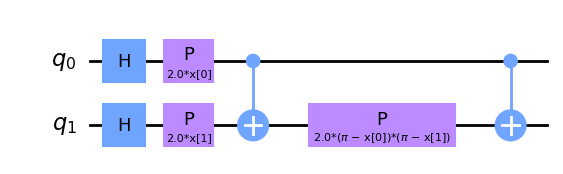

In [29]:
from qiskit.circuit.library import ZZFeatureMap
num_features = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=-1)

No circuito a cima, podemos visualizar $x[0]$ e $x[1]$. Esses parametros são espaços reservados para as nossas features.

### Ansatz

Com os dados codificados, chega a hora de criar o `Ansatz`, um circuito parametrizado. Este circuito é um análogo direto das camadas das redes neurais clássicas, possuindo um conjunto de parametros $\theta[i]$ que são ajustados e otimizados. De forma a minimizar a `função objetivo`, que caracteriza a distancia entre as previsões e os dados rotulados conhecidos.

O termo `Ansatz` é de origem alemã e que pode ser traduzido como "palpite". No entanto, neste contexto, ele representa um palpite calculado e refinado por meio de otimização iterativa. À medida que os parâmetros do Ansatz são ajustados, é necessario verificar os resultados obtidos, refinando-o continuamente para alcançar o melhor desempenho possível.

O Qiskit oferece uma variedade de tipos de `Ansatz`, mas para essa aplicação o [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) já é suficiente. Veja que é necessario passar o `num_qubits`, que nesse caso é igual ao número de features. Além disso, é possível ajustar a quantidade de parâmetros do circuito variando o número de repetições.

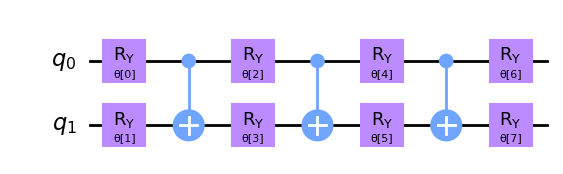

In [30]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=-1)

Em seguida, é um algoritmo de otimização para usar no processo de treinamento.

In [31]:
from qiskit_algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)

### Sampler and Qiskit Runtime

No proximo passo, é necessario escolher onde o classificador será treinado, podendo ser simulador ou utilizando um maquina real para realizar a sua instancia. Se a segunda opção é de interesse do leitor, é possivel fazer isso utilizando o [`QiskitRuntimeService`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService). Aqui, vamos criar um instancia [Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler) que é um simulador oferecido pelo Qiskit.

In [32]:
from qiskit.primitives import Sampler
sampler = Sampler()

Uma função `callback` é muito bem-vinda para visualizar o desempenho do `VQC` em minimizar a `função objetivo`.

In [33]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid()
    plt.show()

### Classifier and Training

Agora finalmente tudo está pronto para criar o nosso classificador quântico.

O VQC utiliza os circuito criados no processo de mapeamento e de `Ansatz`, junto com otimizador e o `Sampler`  para construir uma rede neural quântica de forma simples.

O processo de treinamento pode ser um tanto demorado, especialmente ao realizar simulações. Essa espera pode se tornar ainda mais cansativa, especialmente quando lidamos com circuitos grandes e complexos. Portanto, após horas dedicadas a análises e criação, você decide fazer uma pausa e tomar um café no laboratório, acompanhado pelo Professor Carvalho, enquanto aguarda a conclusão dessa tarefa.

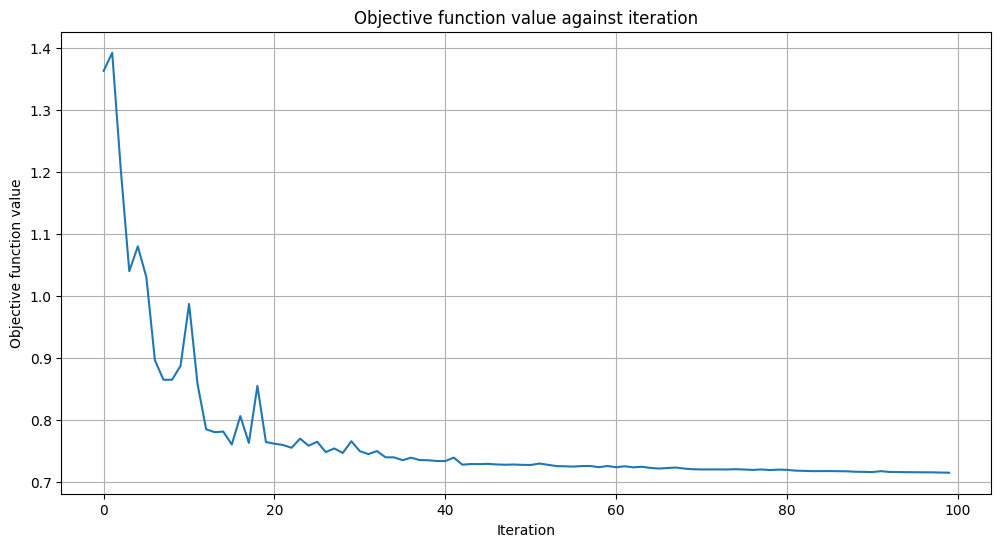

Training time: 61 seconds


In [34]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train.values)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Depois de um tempo você nota que o seu computador terminou o processo de classificação e você corre para testar o seu classificador.

In [35]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC no dataset de treinamento: {train_score_q4:.2f}")
print(f"Quantum VQC no dataset de teste:     {test_score_q4:.2f}")

Quantum VQC no dataset de treinamento: 0.81
Quantum VQC no dataset de teste:     0.86


### Conclusões

Bom, com a pontuação desse classificador, é possivel concluir algumas coisas. O desempenho maior nos dados de teste sugere que o seu modelo se generaliza bem para dados novos. No entanto, é possivel notar um desempenho significativamente menor para o caso de treinamento em relação ao de teste, mas ainda sim é um valor respeitavel. 

O resultado do classificador é promissor e util. No entanto, ao examinarmos mais de perto, surgem algumas limitações que merecem nossa atenção.

Uma dessas limitações é inerente ao problema proposto, e nasce da presença de Pokémon com tipos primários e secundários. Por exemplo, alguns Pokémon podem ser classificados como do tipo aquático em seu primeiro tipo e terrestre em seu segundo tipo. Essa combinação de tipos implica em imunidade a ataques elétricos, adicionando uma camada de complexidade à nossa classificação baseada apenas no tipo primário. 

Além disso, outra limitação está na quantidade de dados disponiveis, que é relativamente pequeno para essa tarefa em especifico. Isso pode resultar em um classificador que não generalize bem para novos dados ou que apresente viés.

Por fim, outra limitação é o estagio de maturidade que o aprendizado de maquina quântico está. Mesmo com diversos algoritmos quânticos que ofereçam vantagens significativas ainda estamos em estagios iniciais dessa ciencia. Assim, é esperado que esses algoritmos evoluam, e que, novos e mais promissores apareçam para demandas especificas. Com o avanço do desenvolvimento de hardware quântico, esse tipo de solução ganha muito potencial para se tornarem uteis e eficazes.

Você finaliza suas conclusões e as apresenta ao professor Carvalho, que fica imediatamente animado com os resultados preliminares e compreende toda a situação. Apos ele analisar, ele verifica que por enquanto, esse classificar vai ser util para essa situação. Com um sorriso no rosto, ele brinca: "Quando a computação quântico estiver em niveis mais avançados, podemos nomear a nova região como `Quanto`."

As palavras do Professor Carvalho deixam você maravilhado com a situação. Sua fome por conhecimento é insaciável, e essa conversa apenas alimentou ainda mais sua fome por descobertas. Essa jornada não é apenas sobre catalogar Pokémon ou desenvolver classificadores; é sobre explorar fronteiras desconhecidas, desafiar limites e abrir novos caminhos na ciência.

### referencias

- https://www.forbes.com/sites/olliebarder/2019/02/27/the-galar-region-in-pokemon-sword-and-shield-looks-a-lot-like-the-united-kingdom/
- https://pokemondb.net/move/rock-throw
- https://pokemon.fandom.com/pt-br/wiki/Professor_Carvalho_(anime)?file=Professor_Oak_JN_anime.png
- https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html
- https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html